# aLAP code
This jupyter notebook contains three approaches to approximating the solution to the Linear Assignment Problem, wherein one finds a weighted matching of some graph that minimizes/maximizes the weight sums.
 The following approaches are listed below, and can be found in the linked papers.
 1.  [Parallel aLAP](https://link.springer.com/content/pdf/10.1007%2F978-3-540-68111-3_74.pdf)
 2.  [Greedy aLAP](https://link.springer.com/content/pdf/10.1007%2F3-540-49116-3_24.pdf) (algorithm 1)
 3.  [Sequential aLAP](https://link.springer.com/content/pdf/10.1007%2F3-540-49116-3_24.pdf) (algorithm 2)

In [108]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# 1.  Parallel aLAP

In [124]:
def parallel_aLAP(cost_matrix, maximize = True):
    if not maximize:
        cost_matrix = -cost_matrix
    num_vert = cost_matrix.shape[0]
    n = 2 * num_vert
    matched = np.empty(n)*np.nan
    cv = np.zeros(n)
    qn = np.zeros(n)
    col_argmax = np.argmax(cost_matrix, axis = 0)
    row_argmax = np.argmax(cost_matrix, axis = 1)
    
    # remove full zero rows and columns (match them)
    col_z = np.count_nonzero(cost_matrix, axis = 0)
    col_z = np.arange(num_vert)[col_z == np.zeros(num_vert)] 
    row_z = np.count_nonzero(cost_matrix, axis = 1)
    row_z = np.arange(num_vert)[row_z == np.zeros(num_vert)]
    mz = min([len(row_z), len(col_z)])
    col_z = col_z[:mz]
    row_z = row_z[:mz]
    
    
    cv[:num_vert] = col_argmax + num_vert  #first half points to second, vice versa
    cv[num_vert:] = row_argmax
    cv[col_z] = row_z + num_vert
    cv[row_z + num_vert] = col_z
    cv = cv.astype(int)
    

    dom_ind = (cv[cv] == np.arange(n))
    matched[dom_ind] = cv[dom_ind] #matched indices, everywhere else nan
    qc, = np.nonzero(dom_ind) #dominating vertices
    

    while len(qc) > 0 and np.isnan(matched).any(): #loop while qc not empty, ie new matchings still being found
        
        temp = np.arange(n)[np.in1d(cv,qc)] #indices of qc in cv
        qt = temp[~np.in1d(temp, matched[qc])] #indices of unmatched verts in cv and qc
        
        qt_p = qt[qt>=num_vert]
        qt_n = qt[qt< num_vert]
        
        m_row = np.arange(num_vert)[np.isnan(matched[num_vert:])] #unmatched rows to check
        m_col = np.arange(num_vert)[np.isnan(matched[:num_vert])]  #unmatched cols
            
        col_argmax = np.argmax(cost_matrix[np.ix_(m_row, qt_n)], axis = 0)
        row_argmax = np.argmax(cost_matrix[np.ix_(qt_p - num_vert, m_col)] , axis = 1)
        
        col_argmax = m_row[col_argmax]
        row_argmax = m_col[row_argmax]
        
        cv[qt_n] = col_argmax + num_vert
        cv[qt_p] = row_argmax
        cv = cv.astype(int)
        
        dom_ind = (cv[cv[qt]] == qt)
        qt = qt[dom_ind]
        matched[qt] = cv[qt] #adding new dominating indices to matching
        matched[cv[qt]] = qt
        #mate[dom_ind] = cv[dom_ind]
        
        qn = np.zeros(n)  #store new matchings
        qn[qt] = qt
        qn[cv[qt]] = cv[qt]
        qc = qn[qn>0].astype(int)
        
    matching = matched[num_vert:]
    rows = np.arange(num_vert)
    matching[np.isnan(matching)] = np.arange(num_vert)[np.isnan(matching)]
    matching = matching.astype(int)
    return (rows, matching)
    

# 2.  Greedy aLAP

In [3]:
def aLAP_greedy(cost_matrix, maximize =True):
    if not maximize:
        cost_matrix=-cost_matrix
 
    n = cost_matrix.shape[0]
    M = np.zeros((n,n))
    U = cost_matrix.astype(float)

    while (~np.isnan(U)).any():
        a, b = np.unravel_index(np.nanargmax(U), (n,n))
        U[a,:] = np.nan
        U[:,b] = np.nan
        M[a, b] = 1

    
    return np.nonzero(M)

# 3.  Sequential aLAP

In [4]:
def aLAP(P, maximize=True):
    if not maximize:
        P=-P
    n = P.shape[0]
    M = np.zeros((n,n))
    U = copy(P)
    C = np.zeros((n,n))
    #R = np.zeros((n,n))
    def try_match(a, b):
        nonlocal n, M, U, C, n_init
        i, j = np.nonzero(U) 
        n_init += 1
        a_free = (M[a,:] == 0).all()
        b_free = (M[b,:] == 0).all()
        a_matched = (M[a,:] != 0).any()
        b_matched = (M[b,:] != 0).any()
        while (M[a,:] == 0).all() and (M[b,:] == 0).all() and \
                (np.count_nonzero(i == a) > 1 or np.count_nonzero(i == b) > 1):
            if (M[a,:] == 0).all() and (np.count_nonzero(i == a) > 1):
                c_ind = np.nonzero(i == a) #indices of vertices adjacent to a
                for c in j[c_ind]: # first vertex not b, assigning to c
                    if c != b:
                        if U[a,c] > U[a,b]: # checking edge weight
                            C[[a,b],[b,a]] = U[[a,b],[b,a]] # moving {a,b} from U to C
                            U[[a,b],[b,a]] = 0
                            i, j = np.nonzero(U)
                            try_match(a, c)
                            break
                        else:
                            C[[a,c],[c,a]] = U[[a,c],[c,a]] # moving {a,c} from U to C
                            U[[a,c],[c,a]] = 0
                            i, j = np.nonzero(U)
                            
            if (M[b,:] == 0).all() and (np.count_nonzero(i == b) > 1):
                d_ind = np.nonzero(i == b)
                for d in j[d_ind]:
                    if d != a:
                        if U[b,d] > U[a,b]:
                            C[[a,b],[b,a]] = U[[a,b],[b,a]] # moving {a,b} from U to C
                            U[[a,b],[b,a]] = 0
                            try_match(b,d)
                            break
                        else:
                            C[[b,d],[d,b]] = U[[b,d],[d,b]] # moving {a,c} from U to C
                            U[[b,d],[d,b]] = 0
                            i, j = np.nonzero(U)
                            
            i, j = np.nonzero(U) #reset i,j
        '''
        if (M[a,:] != 0).any() and (M[b,:] != 0).any():
            C[a,:] = 0
            C[:,a] = 0
            C[b,:] = 0
            C[:,b] = 0
            n_init += 1
            
        elif (M[a,:] != 0).any() and (M[b,:] == 0).all(): #if a is matched, b free
            #R[np.nonzero(C_a)] = C_a[np.nonzero(C_a)]
            C[a,:] = 0
            C[:,a] = 0
            ic, jc = np.nonzero(C)
            d_ind = np.nonzero(ic == b)
            for d in jc[d_ind]:
                if (M[d,:] == 0).all():
                    U[[b,d],[d,b]] = C[[b,d],[d,b]]
                    i, j = np.nonzero(U)
        
                C[[b,d],[d,b]] = 0
                    
            n_init += 1
        
        elif (M[a,:] == 0).all() and (M[b,:] != 0).any(): #if b matched, a free
            #R[np.nonzero(C_b)] = C_b[np.nonzero(C_b)]
            C[b,:] = 0
            C[:,b] = 0
            ic, jc = np.nonzero(C)
            c_ind = np.nonzero(ic == a)
            for c in jc[c_ind]:
                if (M[c,:] == 0).all():
                    U[[a,c],[c,a]] = C[[a,c],[c,a]]
                    i, j = np.nonzero(U)
                C[[a,c],[c,a]] = 0
            n_init += 1
        '''
        if (M[a,:] == 0).all() and (M[b,:] == 0).all():
            #R[np.nonzero(C_a)] = C_a[np.nonzero(C_a)]
            #R[np.nonzero(C_b)] = C_b[np.nonzero(C_b)]
            C[[a,b],[b,a]] = 0
            
            if (np.count_nonzero(i == a) == 1) and (np.count_nonzero(i == b) == 1):
                U[[a,b],[b,a]] = 0
            i, j = np.nonzero(U) #reset i,j
            M[[a,b],[b,a]] = 1
                    
            
    n_init = 0
    while (U != 0).any():
        i, j = np.nonzero(U)
        index = random.randrange(len(i))
        #index = 0
        a = i[index]
        b = j[index]
        try_match(a, b)
        
        
    #print("time try_match called: " ,n_init)
    return np.nonzero(M)
        

# Baseline Performance
To demonstrate that the algorithms (specifically the parallel implementation) are working as expected, we will compare the maximum matching on returned on a few matrices from the QAPLIB using parallel_aLAP() and linear_sum_assignment()  (LSAP) from scipy.optimize, the latter of which returns an exact solution. The algorithm guarantees a solution atleast one half of optimal.


In [5]:
from scipy.optimize import linear_sum_assignment

In [126]:
qapprob = ["chr12a","chr15a","chr15a","chr20a","chr22a", "chr25a"]
datafile = np.load("qap_probs.npz",allow_pickle=True)
lap = np.zeros(len(qapprob))
alap = np.zeros(len(qapprob))
for i, p in enumerate(qapprob):
    A = datafile[p][1]
    lap[i] = A[linear_sum_assignment(A, maximize = True)].sum()
    alap[i] = A[parallel_aLAP(A, maximize = True)].sum()
    
mat = np.zeros((len(qapprob),3))
mat[:,0] = lap
mat[:,1] = alap
mat[:,2] = alap/lap
df = pd.DataFrame(mat,columns=["Scipy", "aLAP", "Ratio (aLAP/Scipy)"])
df.insert(0,"QAP",qapprob,True)
print(df)


      QAP   Scipy    aLAP  Ratio (aLAP/Scipy)
0  chr12a  1034.0  1022.0            0.988395
1  chr15a  1293.0  1158.0            0.895592
2  chr15a  1293.0  1158.0            0.895592
3  chr20a   176.0   160.0            0.909091
4  chr22a  1354.0  1354.0            1.000000
5  chr25a  1452.0  1416.0            0.975207


# Time complexity
To further investigate the performance of both aLAP and LSAP, we will run each with simulated dense cost matrices (adjacency matrix for complete graphs) of various sizes, oberving how the algorithms perform as the number of nodes (and, consquently, edges) increases.

In [107]:
# random dense matrix, entries [0,99]
def dense_matrix(num):  #num = number of nodes in adjacency matrix
    matrix = np.zeros((num,num))
    for row in range(num):
        for col in range(num):
            matrix[row,col] = random.uniform(0,100)
    return matrix

In [110]:
import time
import timeit
n = [50, 100, 150, 200, 250, 300, 350,500,750, 1000, 1250, 1500,
     1750, 2000, 2250, 2500, 2750, 3000]
scipy = np.zeros(len(n))
alap = np.zeros(len(n))
reps = 5

for i, node in enumerate(n):
    for j in range(reps):
        mysetup_s = '''
from scipy.optimize import linear_sum_assignment
from __main__ import  node, dense_matrix
import numpy as np
A = dense_matrix(node)'''
        mycode_s = 'linear_sum_assignment(-A)'
        scipy[i] = scipy[i] + timeit.timeit(setup = mysetup_s, stmt = mycode_s, number = 2)/2

        mysetup_p = '''
from __main__ import  node, dense_matrix, parallel_aLAP
import numpy as np
A = dense_matrix(node)'''
        mycode_p = 'parallel_aLAP(A)'
        alap[i] = alap[i] + timeit.timeit(setup = mysetup_p, stmt = mycode_p, number = 2)/2
        
    scipy[i] = scipy[i]/reps
    alap[i] = alap[i]/reps
    #print(i)

Text(0.15, 0.8, 'R^2 = 0.9535166484240681')

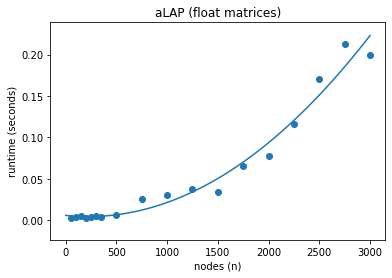

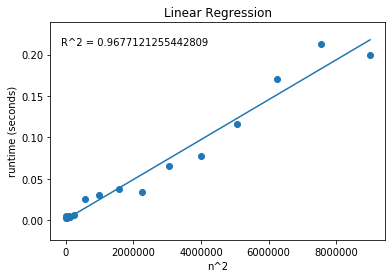

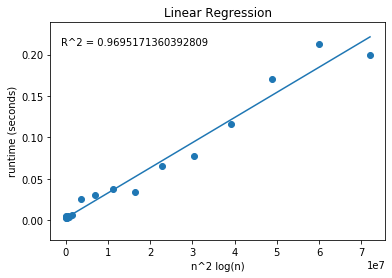

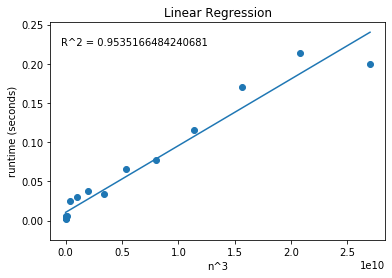

In [111]:
from scipy.stats import linregress
plt.scatter(n, alap)
# coef = np.polyfit([i**2 for i in n], alap[:,0], 2)
coef = np.polyfit(n, alap, 3)
y_new = np.poly1d(coef)
plt.plot(np.linspace(0,max(n),100), y_new(np.linspace(0,max(n),100)))
plt.title("aLAP (float matrices)")
plt.ylabel('runtime (seconds)')
plt.xlabel('nodes (n)')

plt.figure()
plt.scatter([(i**2) for i in n], alap)
# coef = np.polyfit([(i**2) for i in n], alap[:,0], 1)
# y_new = np.poly1d(coef)
res = linregress([i**2 for i in n], alap)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**2) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Linear Regression")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^2')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))

plt.figure()
plt.scatter([(i**2)*np.log(i) for i in n], alap)
res = linregress([(i**2)*np.log(i) for i in n], alap)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**2)*np.log(i) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Linear Regression")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^2 log(n)')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))

plt.figure()
plt.scatter([(i**3) for i in n], alap)
res = linregress([(i**3) for i in n], alap)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**3) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Linear Regression")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^3')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))

Text(0.15, 0.8, 'R^2 = 0.9880995704876614')

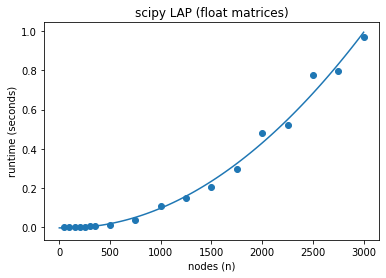

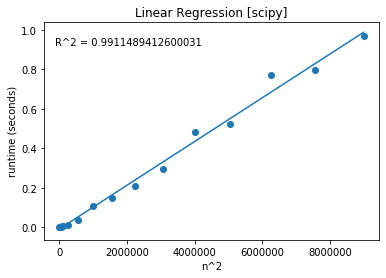

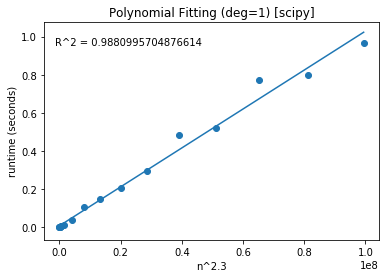

In [112]:

plt.scatter(n, scipy)
# coef = np.polyfit([i**2 for i in n], alap[:,0], 2)
coef = np.polyfit(n, scipy, 2)
y_new = np.poly1d(coef)
plt.plot(np.linspace(0,max(n),100), y_new(np.linspace(0,max(n),100)))
plt.title("scipy LAP (float matrices)")
plt.ylabel('runtime (seconds)')
plt.xlabel('nodes (n)')

# plt.figure()
# plt.scatter([(i**2)*np.log(i) for i in n], scipy[:,0])
# coef = np.polyfit([(i**2)*np.log(i) for i in n], scipy[:,0], 1)
# y_new = np.poly1d(coef)
# m = np.max([(i**2)*np.log(i) for i in n])
# plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
# print(coef)

plt.figure()
plt.scatter([(i**2) for i in n], scipy)
# coef = np.polyfit([i**2 for i in n], scipy[:,0], 1)
# y_new = np.poly1d(coef)
res = linregress([i**2 for i in n], scipy)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**2) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Linear Regression [scipy]")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^2')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))

plt.figure()
plt.scatter([(i**2.3) for i in n], scipy)
res = linregress([i**2.3 for i in n], scipy)
y_new = np.poly1d([res[0], res[1]])
m = np.max([(i**2.3) for i in n])
plt.plot(np.linspace(0,m,100), y_new(np.linspace(0,m,100)))
plt.title("Polynomial Fitting (deg=1) [scipy]")
plt.ylabel('runtime (seconds)')
plt.xlabel('n^2.3')
plt.figtext(0.15,0.80, 'R^2 = '+ str(res[2]**2))


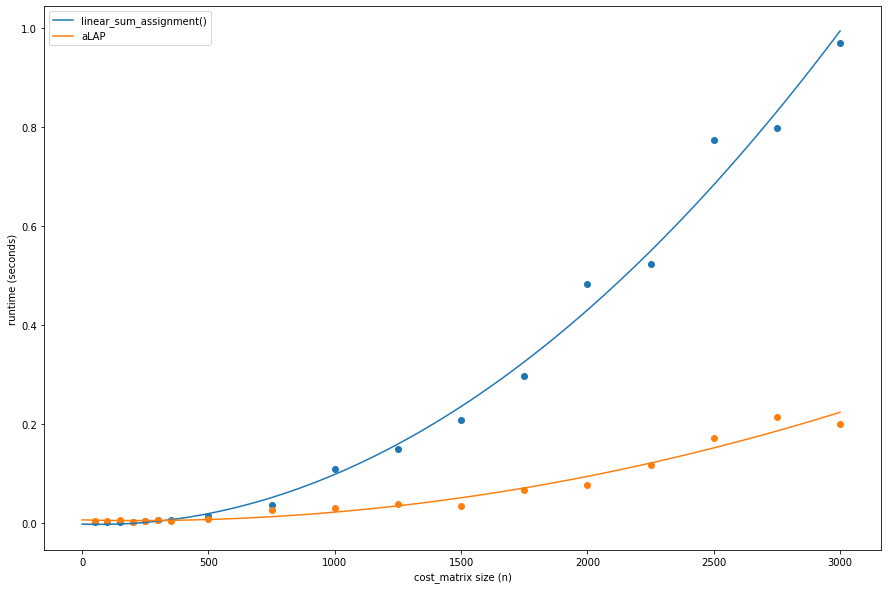

In [121]:
plt.figure(figsize=(15,10))
plt.scatter(n, scipy)
coef = np.polyfit(n, scipy, 2)
y_new = np.poly1d(coef)
plt.plot(np.linspace(0,max(n),100), y_new(np.linspace(0,max(n),100)), label = 'linear_sum_assignment()')

plt.scatter(n, alap)
coef = np.polyfit(n, alap, 3)
y_new = np.poly1d(coef)
plt.plot(np.linspace(0,max(n),100), y_new(np.linspace(0,max(n),100)), label = 'aLAP')
plt.ylabel('runtime (seconds)')
plt.xlabel('cost_matrix size (n)')
plt.legend()
plt.savefig('time_lapvalap')

As we can see, performance of aLAP scales better as the size of the cost matrix increases

In [149]:
import time
import timeit
n = [50, 100, 150, 200, 250, 300, 350,500,750, 1000, 1250, 1500,
     1750, 2000, 2250, 2500, 2750, 3000]
alap_ac = np.zeros(len(n))
#lap_score = np.zeros(len(n))
reps = 15

for i, node in enumerate(n):
    for j in range(reps):
        A = dense_matrix(node)
        true = A[linear_sum_assignment(A, maximize = True)].sum()
        alap_sum = A[parallel_aLAP(A, maximize = True)].sum()
        alap_ac[i] = alap_ac[i] + (true - alap_sum)/true
        
    alap_ac[i] = alap_ac[i]/reps

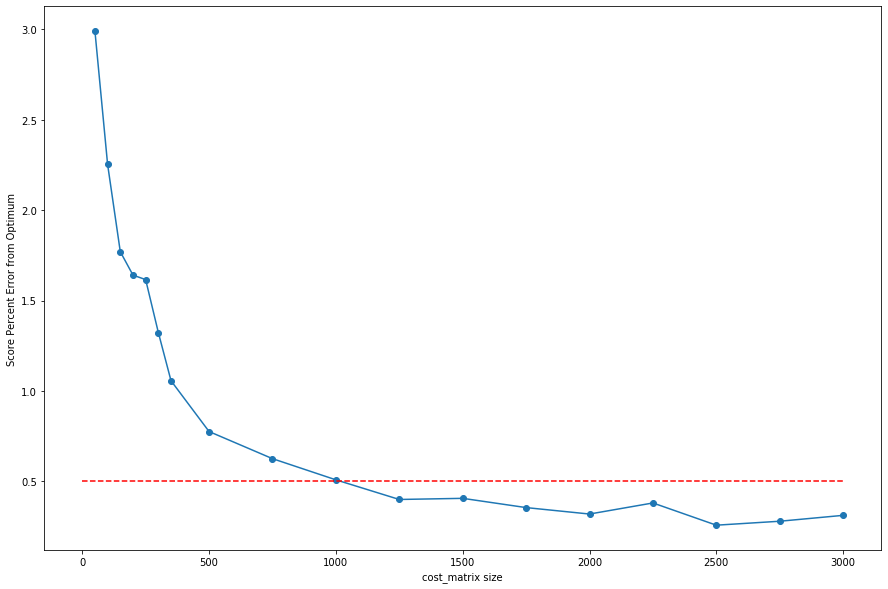

In [153]:
plt.figure(figsize=(15,10))
plt.plot(n, alap_ac *100, marker = 'o')
coef = np.polyfit(n, alap_ac, 2)
y_new = np.poly1d(coef)
#plt.plot(np.linspace(0,max(n),100), y_new(np.linspace(0,max(n),100)))
plt.plot(np.linspace(0,max(n),100), 0.5 * np.ones(100), 'r-', linestyle = 'dashed')
plt.xlabel('cost_matrix size')
plt.ylabel('Score Percent Error from Optimum')
plt.savefig('perdiff_lapvalap')

# Runtime as a function of cost matrix density (edgeset size)

In [12]:
# random sparse matrix, entries [0,99]
def sparse_matrix(n,m): # n = number of nodes, m = number of edges
    m = int(m)
    matrix = np.zeros((n,n))
    rows = random.sample(range(n**2), m)
    for i in range(n):
        for j in range(n):
            if (i*n + j) in rows:
                matrix[i,j] = random.randrange(100)
    return matrix


In [65]:
import timeit
mysetup = '''
from graspy.simulations import er_nm
from scipy.optimize import linear_sum_assignment
from __main__ import dense_matrix, parallel_aLAP
import numpy as np
n = 1000
G1 = er_nm(n,10*n)
G2 = dense_matrix(n)
G = np.multiply(G1,G2)'''
mycode = '''
linear_sum_assignment(-G)'''

mycode2 = '''
parallel_aLAP(G)'''
print('n = 1000 nodes, 10*n edges')
scipy_t = timeit.timeit(setup = mysetup, stmt = mycode, number = 10)/10
alap_t = timeit.timeit(setup = mysetup, stmt = mycode2, number = 10)/10
print('scipy runtime: ' , scipy_t)
print('alap runtime: ' , alap_t)
print('ratio (alap/scipy): ', alap_t/scipy_t)

n = 1000 nodes, 10*n edges
scipy runtime:  0.046977725800024926
alap runtime:  0.012951904400051718
ratio (alap/scipy):  0.2757030950196581


In [61]:
from graspy.simulations import er_nm
from scipy.optimize import linear_sum_assignment
import time
n = 100
G1 = er_nm(n,10*n)
G2 = dense_matrix(n)
G = np.multiply(G1,G2)
Ml = parallel_aLAP(G)
print("score: " , G[Ml].sum())
Ms = linear_sum_assignment(-G)
print("score: " , G[Ms].sum())
print('score ratio (alap/lap): ', G[Ml].sum()/ G[Ms].sum())

score:  8532.767421843613
score:  9149.739826779025
score ratio (alap/lap):  0.9325694045278002


0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'runtime (sec)')

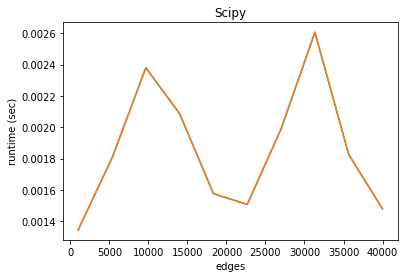

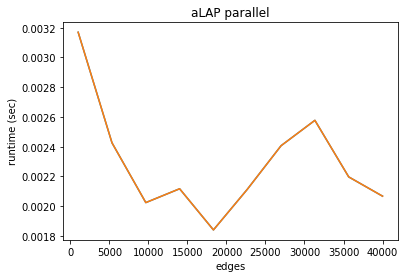

In [13]:
n = 200
m = np.linspace(1000, n**2, 10)
scipy_sc = np.zeros((len(m), 2))
alap_sc = np.zeros((len(m), 2))
reps = 5

for i, edge in enumerate(m):
    for j in range(reps):
        mysetup_s = '''
from scipy.optimize import linear_sum_assignment
from __main__ import  edge, sparse_matrix
import numpy as np
n = 200
A = sparse_matrix(n, edge)'''
        mycode_s = 'linear_sum_assignment(-A)'
        scipy_sc[i] = scipy_sc[i] + timeit.timeit(setup = mysetup_s, stmt = mycode_s, number = 2)/2

        mysetup_p = '''
from __main__ import  edge, sparse_matrix, parallel_aLAP
import numpy as np
n = 200
A = sparse_matrix(n, edge)'''
        mycode_p = 'parallel_aLAP(A)'
        alap_sc[i] = alap_sc[i] + timeit.timeit(setup = mysetup_p, stmt = mycode_p, number = 2)/2

    scipy_sc[i] = scipy_sc[i]/reps
    alap_sc[i] = alap_sc[i]/reps

    
plt.plot(m, scipy_sc)
plt.xlabel('edges')
plt.ylabel('runtime (sec)')
plt.title('Scipy')
plt. figure()
plt.plot(m, alap_sc)
plt.title('aLAP parallel')
plt.xlabel('edges')
plt.ylabel('runtime (sec)')



From the figures above, neither algorithm has traceble trends in runtime due to cost matrix density. This is likely due to the graph representation as an adjacency matrix. The approximation algorithms for LAP depend on the fact that the graph be represented as a group of edges with associated weight, with the time complexity dependent on the number of weighted edges. However, by using an adjacency matrix, we are essentially operating on a complete graph, with "no edges" treated as "edges with weight zero". For this reason, sparcity does not effect runtime or complexity of aLAP, since the algorithm will check over each possible existing edge atleast once. Additionally, as FAQ is dependent on matrix operations, it is necessary that our linear assignment solver take in cost functions in the form of a matrix. For these reasons, I don't think it is worth further investigating aLAP as a method to speed up FAQ.

# Somewhat unrelated: aLAP in QAP

In [99]:
import time 
qapprob = ["bur26a", "bur26b", "bur26c", "bur26d", "bur26e", "bur26f",
              "bur26g", "bur26h", "chr12a", "chr12b", "chr12c", "chr15a",
              "chr15b", "chr15c", "chr18a", "chr18b", "chr20a", "chr20b",
              "chr20c", "chr22a", "chr22b", "chr25a",
              "els19",
              "esc16a", "esc16b", "esc16c", "esc16d", "esc16e", "esc16g",
              "esc16h", "esc16i", "esc16j", "esc32g", "esc128",
              "had12", "had14", "had16", "had18", "had20", "kra30a",
              "kra30b", "kra32",
              "lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
              "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
              "lipa80a", "lipa90a", "lipa90b",
              "nug12", "nug14", "nug16a", "nug16b", "nug17", "nug18", "nug20",
              "nug21", "nug22", "nug24", "nug25", "nug27", "nug28", "nug30",
              "rou12", "rou15", "rou20",
              "scr12", "scr15", "scr20",
              "sko42", "sko49", "sko56", "sko64", "sko72", "sko81", "sko90",
              "sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",
              "ste36b", "ste36c",
              "tai12a", "tai12b", "tai15a", "tai15b", "tai17a", "tai20a",
              "tai20b", "tai25a", "tai25b", "tai30a", "tai30b", "tai35a",
              "tai40a", "tai40b", "tai50a", "tai50b", "tai60a", "tai60b",
              "tai64c", "tai80a", "tai100a", "tai100b", "tai150b", "tai256c",
              "tho30", "tho40", "tho150", "wil50", "wil100"]
qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b","esc16b",
          "rou12","rou15","rou20","tai12a","tai15a","tai17a","tai20a",
          "tai30a","tai35a","tai40a"]


slnfile = np.load("qap_sols.npz",allow_pickle=True)
datafile = np.load("qap_probs.npz",allow_pickle=True)
n_qap = len(qapprob)
scipy_scores = np.zeros((n_qap,2))
alap_scores = np.zeros((n_qap,2))
den = 1
for i in range(n_qap):
    c_min = [0]*den
    b_min = [0]*den
    u_min = [0]*den
    for k in range(den):
        A = datafile[qapprob[i]][0]
        B = datafile[qapprob[i]][1]
        n = A.shape[0]
        start = time.time()
        res = quadratic_assignment(A,B, options={'init_weight': 0.5, 'init_n': 30})
        scipy_scores[i,1] = (time.time() - start)
        #scipy_scores[i,1] = res['nit']
        c_min[k] = res['score']
            
        start = time.time()
        res = quadratic_assignment_aLAP(A,B, options={'init_weight': 0.5, 'init_n': 30, 'eps': 0.05})
        alap_scores[i,1] = (time.time() - start)
        #alap_scores[i,1] = res['nit']
        b_min[k] = res['score']
        
        
    scipy_scores[i,0] = min(c_min)
    alap_scores[i,0] = min(b_min)


In [104]:
import pandas as pd
opt = [slnfile[i] for i in qapprob]
mat = np.zeros((n_qap,5))
mat[:,0] = opt
mat[:,1] = alap_scores[:,0]
mat[:,2] = alap_scores[:,1]
mat[:,3] = scipy_scores[:,0]
mat[:,4] = scipy_scores[:,1]
#mat[:,1] = (bari_scores-opt)/opt
#mat[:,2] = (convex_scores-opt)/opt
#(bari_scores-opt)/opt
df = pd.DataFrame(mat,columns=["OPT","aLAP", "aLAP time", "scipy", "scipy time"])
df.insert(0,"QAP",qapprob,True)
print(df)

       QAP        OPT       aLAP  aLAP time      scipy  scipy time
0   chr12c    11156.0    12176.0   0.957180    12322.0    0.756619
1   chr15a     9896.0    11716.0   1.030711    10108.0    0.742376
2   chr15c     9504.0    12698.0   0.968232    12136.0    0.846084
3   chr20b     2298.0     2872.0   1.343245     2854.0    0.932337
4   chr22b     6194.0     7040.0   1.119524     7240.0    0.862945
5   esc16b      292.0      292.0   1.342118      292.0    0.843279
6    rou12   235528.0   241844.0   0.644371   235528.0    0.846084
7    rou15   354210.0   387716.0   0.497635   363354.0    0.797452
8    rou20   725522.0   744972.0   0.901474   734392.0    1.232558
9   tai12a   224416.0   241722.0   0.484759   224416.0    1.098458
10  tai15a   388214.0   452594.0   0.453666   390258.0    0.822401
11  tai17a   491812.0   497780.0   0.929372   498214.0    0.798237
12  tai20a   703482.0   789062.0   0.675579   712618.0    0.882434
13  tai30a  1818146.0  2033048.0   0.677456  1853424.0    1.26

Text(0, 0.5, 'Runtime (s)')

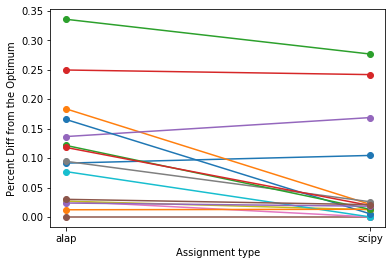

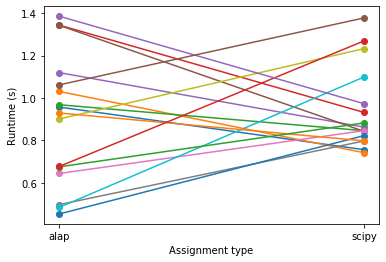

In [105]:
mat = np.zeros((n_qap,2))
mat[:,0] = (alap_scores[:,0]-opt)/opt
mat[:,1] = (scipy_scores[:,0]-opt)/opt
plt.plot(['alap','scipy'],mat.T, marker='o')
plt.xlabel('Assignment type')
plt.ylabel('Percent Diff from the Optimum')
plt.figure()
mat = np.zeros((n_qap,2))
mat[:,0] = alap_scores[:,1]
mat[:,1] = scipy_scores[:,1]
plt.plot(['alap','scipy'],mat.T, marker='o')
plt.xlabel('Assignment type')
plt.ylabel('Runtime (s)')


In [31]:
np.arange(n_qap)[(alap_scores[:,0]-opt)/opt < 0]
print(mat[5,:])


[3.78204400e+06 2.95237300e+06 1.76308870e-01 3.78269300e+06
 1.18349791e+00]


In [103]:
import numpy as np
import operator
from scipy.optimize import linear_sum_assignment, minimize_scalar, OptimizeResult


def quadratic_assignment_aLAP(
    cost_matrix,
    dist_matrix,
    maximize=False,
    options=None
):
    r"""
    Solve the quadratic assignment problem.

    This function solves the Quadratic Assignment Problem (QAP) and the
    Graph Matching Problem through an implementation of the Fast
    Approximate QAP Algorithm (FAQ) (these two problems are the same up
    to a sign change) [1]_.

    Quadratic Assignment solves problems of the following form:

    .. math::

        \min_P & \ {\ \text{trace}(APB^T P^T)}\\
        \mbox{s.t. } & {P \ \epsilon \ \mathcal{P}}\\

    where :math:`\mathcal{P}` is the set of all permutation matrices,
    and :math:`A` and :math:`B` are adjacency matrices.

    This algorithm can be thought of as finding an alignment of the
    vertices of two graphs which minimizes the number of induced edge
    disagreements, or, in the case of weighted graphs, the sum of squared
    differences of edge weight disagreements. The option to add seeds
    (known vertex correspondence between some nodes) is also available
    [2]_.

    Note that the quadratic assignment problem is NP-hard, is not
    known to be solvable in polynomial time, and is computationally
    intractable. Therefore, the results given are approximations,
    not guaranteed to be exact solutions.


    Parameters
    ----------
    cost_matrix : 2d-array, square, non-negative
        A square adjacency matrix. In this implementation, :math:`A` =
        `cost-matrix` in the objective function above.

    dist_matrix : 2d-array, square, non-negative
        A square adjacency matrix.  In this implementation, :math:`B` =
        `dist-matrix` in the objective function above.

    partial_match : 2d-array, optional, (default = None)
        Allows the user apply a seed, fixing part of the matching between
        the two adjacency matrices.
        For column 1, each entry is an index of a node in `cost_matrix`.
        For column 2, each entry is an index of a node in `dist_matrix`.
        The elements of ``seed[:, 0]`` and ``seed[:, 1]`` are vertices
        which are known to be matched, that is, ``seed[i, 0]`` is matched to
        vertex ``seed[i, 1]``. Array shape ``(m , 2)`` where ``m <= number of
        nodes``.

    maximize : bool (default = False)
        Gives users the option to solve the Graph Matching Problem (GMP)
        rather than QAP. This is accomplished through trivial negation
        of the objective function.


    options : dict, optional
        A dictionary of solver options. All methods accept the following
        options:

            init : 2d-array (default = 'barycenter')
                The algorithm may be sensitive to the initial permutation
                matrix (or search position) chosen due to the possibility
                of several local minima within the feasible region.
                With only 1 initialization, a barycenter init will
                likely return a more accurate permutation.

                Choosing several random initializations (through
                `init_weight` and `init_n`) as opposed to the non-informative
                barycenter will likely result in a more accurate result at
                the cost of higher runtime.

                The initial position chosen:

                "barycenter" : the non-informative "flat doubly stochastic
                matrix," :math:`J=1*1^T /n` , i.e the barycenter of the
                feasible region (where :math:`n` is the number of nodes and
                :math:`1` is a ``(n, 1)`` array of ones).

                If an ndarray is passed, it should have the same shape as
                `cost_matrix` and `dist_matrix`, and its rows and columns
                must sum to 1 (doubly stochastic).
            init_weight : float, positive in range [0,1] (Default = None)
                Allows the user to specify the amount of random perturbation
                from the starting position of `init`
                At each initialization, the initial permutation matrix
                is some random point near :math:`J`, defined as
                :math:`(\alpha J + (1- \alpha) K`, where :math:`\alpha`
                is `init_weight` and :math:`K` is some random doubly
                stochastic matrix.
            init_n : int, positive (default = 1)
                Number of random initializations of the starting
                permutation matrix that the FAQ algorithm will undergo.
            maxiter : int, positive (default = 30)
                Integer specifying the max number of Franke-Wolfe iterations.
                FAQ typically converges with modest number of iterations.
            shuffle_input : bool (default = True)
                To avoid artificially high or low matching due to inherent
                sorting of input adjacency matrices, gives users the option
                to shuffle the nodes of `cost_matrix`. Results are then
                unshuffled so that returned `col_ind` matches the node order
                of inputs.
            eps : float (default = 0.05)
                A positive, threshold stopping criteria such that Franke-
                Wolfe continues to iterate while Frobenius norm of
                :math:`(P_{i}-P_{i+1}) > eps`, where :math:`i` is the
                iteration number.

    Returns
    -------
    res : OptimizeResult
        A :class:`scipy.optimize.OptimizeResult` consisting of the fields:

            col_ind : 1-D array
                An array of column indices corresponding to the optimal
                permutation (with the fixed seeds given) of the
                nodes of `dist_matrix`, to best minimize the objective
                function.
            score : float
                The optimal value of the objective function.
            nit : int
                The total number of Franke-Wolfe iterations performed during
                optimization.

    References
    ----------
    .. [1] J.T. Vogelstein, J.M. Conroy, V. Lyzinski, L.J. Podrazik,
           S.G. Kratzer, E.T. Harley, D.E. Fishkind, R.J. Vogelstein, and
           C.E. Priebe, "Fast approximate quadratic programming for graph
           matching," PLOS one, vol. 10, no. 4, p. e0121002, 2015.

    .. [2] D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski,
           C. Priebe, "Seeded graph matching", Pattern Recognit. 87 (2019):
           203-215.

    Examples
    --------

    >>> cost = np.array([[0, 80, 150, 170], [80, 0, 130, 100],
    ...         [150, 130, 0, 120], [170, 100, 120, 0]])
    >>> dist = np.array([[0, 5, 2, 7], [0, 0, 3, 8],
    ...         [0, 0, 0, 3], [0, 0, 0, 0]])
    >>> from scipy.optimize import quadratic_assignment
    >>> res = quadratic_assignment(cost, dist)
    >>> print(res)
     col_ind: array([0, 3, 2, 1])
         nit: 9
       score: 3260

    To demonstrate explicitly how the `score` value
    :math:`f(P) = trace(A^T PBP^T )` is calculated, one may construct the
    permutation matrix, and perform the necessary algebra.

    >>> n = cost.shape[0]
    >>> P = np.zeros((n, n))
    >>> P[np.arange(n), res['col_ind']] = 1
    >>> score = int(np.trace(cost.T @ P @ dist @ P.T))
    >>> print(score)
    3260

    As you can see, the value here matches res['score'] reported above.
    Alternatively, to avoid constructing the permutation matrix, one can also
    perform the following calculation.

    >>> score = np.trace(cost.T @ dist[np.ix_(res['col_ind'], res['col_ind'])])
    >>> print(score)
    3260

    Here, we are simply permuting the distance matrix.

    """

    if options is None:
        options = {}

    return _quadratic_assignment_faq(cost_matrix, dist_matrix, maximize,
                                     **options)


def _quadratic_assignment_faq(
        cost_matrix,
        dist_matrix,
        maximize=False,
        partial_match=None,
        init="barycenter",
        init_weight=None,
        init_n=1,
        maxiter=30,
        shuffle_input=True,
        eps=0.05
):

    cost_matrix = np.asarray(cost_matrix)
    dist_matrix = np.asarray(dist_matrix)

    if partial_match is None:
        partial_match = np.array([[], []]).T
    partial_match = np.asarray(partial_match)
    init_n = operator.index(init_n)
    maxiter = operator.index(maxiter)

    # ValueError check
    msg = None
    if cost_matrix.shape[0] != cost_matrix.shape[1]:
        msg = "'cost_matrix' must be square"
    elif dist_matrix.shape[0] != dist_matrix.shape[1]:
        msg = "'dist_matrix' must be square"
    elif cost_matrix.shape != dist_matrix.shape:
        msg = "Adjacency matrices must be of equal size"
    elif (cost_matrix < 0).any() or (dist_matrix < 0).any():
        msg = "Adjacency matrix contains negative entries"
    elif partial_match.shape[0] > cost_matrix.shape[0]:
        msg = "There cannot be more seeds than there are nodes"
    elif partial_match.shape[1] != 2:
        msg = "`partial_match` must have two columns"
    elif (partial_match < 0).any():
        msg = "`partial_match` contains negative entries"
    elif (partial_match >= len(cost_matrix)).any():
        msg = "`partial_match` entries must be less than the number of nodes"
    elif not len(set(partial_match[:, 0])) == len(partial_match[:, 0]) or not \
            len(set(partial_match[:, 1])) == len(partial_match[:, 1]):
        msg = "`partial_match` column entries must be unique"
    elif isinstance(init, str) and init not in {'barycenter'}:
        msg = "Invalid 'init' parameter string"
    elif init_weight is not None and (init_weight < 0 or init_weight > 1):
        msg = "'init_weight' must be in range [0, 1]"
    elif init_n <= 0:
        msg = "'n_init' must be a positive integer"
    elif maxiter <= 0:
        msg = "'maxiter' must be a positive integer"
    if msg is not None:
        raise ValueError(msg)

    # TypeError check
    if type(shuffle_input) is not bool:
        msg = "'shuffle_input' must be a boolean"
    elif eps <= 0 or type(eps) is not float:
        msg = "'eps' must be a positive float"
    elif type(maximize) is not bool:
        msg = "'maximize' must be a boolean"
    if msg is not None:
        raise TypeError(msg)

    rng = np.random.RandomState()
    n = cost_matrix.shape[0]  # number of vertices in graphs
    n_seeds = partial_match.shape[0]  # number of seeds
    n_unseed = n - n_seeds

    perm_inds = np.zeros(n)

    obj_func_scalar = 1
    if maximize:
        obj_func_scalar = -1
    score = obj_func_scalar * np.inf

    seed_dist_c = np.setdiff1d(range(n), partial_match[:, 1])
    if shuffle_input:
        seed_dist_c = rng.permutation(seed_dist_c)
        # shuffle_input to avoid results from inputs that were already matched

    seed_cost_c = np.setdiff1d(range(n), partial_match[:, 0])
    permutation_cost = np.concatenate([partial_match[:, 0],
                                       seed_cost_c], axis=None).astype(int)
    permutation_dist = np.concatenate([partial_match[:, 1],
                                       seed_dist_c], axis=None).astype(int)
    cost_matrix = cost_matrix[np.ix_(permutation_cost, permutation_cost)]
    dist_matrix = dist_matrix[np.ix_(permutation_dist, permutation_dist)]

    # definitions according to Seeded Graph Matching [2].
    A11 = cost_matrix[:n_seeds, :n_seeds]
    A12 = cost_matrix[:n_seeds, n_seeds:]
    A21 = cost_matrix[n_seeds:, :n_seeds]
    A22 = cost_matrix[n_seeds:, n_seeds:]
    B11 = dist_matrix[:n_seeds, :n_seeds]
    B12 = dist_matrix[:n_seeds, n_seeds:]
    B21 = dist_matrix[n_seeds:, :n_seeds]
    B22 = dist_matrix[n_seeds:, n_seeds:]

    for i in range(init_n):
        # setting initialization matrix
        if isinstance(init, str) and init == 'barycenter':
            J = np.ones((n_unseed, n_unseed)) / float(n_unseed)
        else:
            _check_init_input(init, n_unseed)
            J = init
        if init_weight is not None:
            # generate a nxn matrix where each entry is a random number [0, 1]
            K = rng.rand(n_unseed, n_unseed)
            # Sinkhorn balancing
            K = _doubly_stochastic(K)
            # initialize J, a doubly stochastic barycenter
            P = J * init_weight + (1 - init_weight) * K
        else:
            P = J
        const_sum = A21 @ B21.T + A12.T @ B12
        grad_P = np.inf  # gradient of P
        n_iter = 0  # number of FW iterations

        # OPTIMIZATION WHILE LOOP BEGINS
        while grad_P > eps and n_iter < maxiter:
            # computing the gradient of f(P) = -tr(APB^tP^t)
            delta_f = (const_sum + A22 @ P @ B22.T + A22.T @ P @ B22)
            # run hungarian algorithm on gradient(f(P))
            rows, cols = parallel_aLAP(delta_f, maximize)
            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1  # initialize search direction matrix Q

            def f(x):  # computing the original optimization function
                return obj_func_scalar * (
                    np.trace(A11.T @ B11)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21.T)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12.T @ B12)
                    + np.trace(
                        A22.T
                        @ (x * P + (1 - x) * Q)
                        @ B22
                        @ np.transpose(x * P + (1 - x) * Q)
                    )
                )

            alpha = minimize_scalar(
                f, bounds=(0, 1), method="bounded"
            ).x  # computing the step size
            P_i1 = alpha * P + (1 - alpha) * Q  # Update P
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            n_iter += 1
        # end of FW optimization loop
        
        grad_P = np.inf  # gradient of P
        while grad_P > eps and n_iter < maxiter:
            # computing the gradient of f(P) = -tr(APB^tP^t)
            delta_f = (const_sum + A22 @ P @ B22.T + A22.T @ P @ B22)
            # run hungarian algorithm on gradient(f(P))
            rows, cols = linear_sum_assignment(delta_f, maximize)
            Q = np.zeros((n_unseed, n_unseed))
            Q[rows, cols] = 1  # initialize search direction matrix Q

            def f(x):  # computing the original optimization function
                return obj_func_scalar * (
                    np.trace(A11.T @ B11)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A21 @ B21.T)
                    + np.trace(np.transpose(x * P + (1 - x) * Q) @ A12.T @ B12)
                    + np.trace(
                        A22.T
                        @ (x * P + (1 - x) * Q)
                        @ B22
                        @ np.transpose(x * P + (1 - x) * Q)
                    )
                )

            alpha = minimize_scalar(
                f, bounds=(0, 1), method="bounded"
            ).x  # computing the step size
            P_i1 = alpha * P + (1 - alpha) * Q  # Update P
            grad_P = np.linalg.norm(P - P_i1)
            P = P_i1
            n_iter += 1
            
        row, col = linear_sum_assignment(
            -P
        )  # Project onto the set of permutation matrices
        perm_inds_new = np.concatenate(
            (np.arange(n_seeds), np.array([x + n_seeds for x in col]))
        ).astype(int)

        score_new = np.trace(
            np.transpose(cost_matrix)
            @ dist_matrix[np.ix_(perm_inds_new, perm_inds_new)]
        )  # computing objective function value

        if obj_func_scalar * score_new < obj_func_scalar * score:  # minimizing
            score = score_new
            perm_inds = np.zeros(n, dtype=int)
            perm_inds[permutation_cost] = permutation_dist[perm_inds_new]

    permutation_cost_inv = np.argsort(permutation_cost)
    cost_matrix = cost_matrix[
        np.ix_(permutation_cost_inv, permutation_cost_inv)
    ]
    permutation_dist_inv = np.argsort(permutation_dist)
    dist_matrix = dist_matrix[
        np.ix_(permutation_dist_inv, permutation_dist_inv)
    ]

    score = np.trace(
        np.transpose(cost_matrix) @ dist_matrix[np.ix_(perm_inds, perm_inds)]
    )

    res = {"col_ind": perm_inds, "score": score, "nit": n_iter}

    return OptimizeResult(res)


def _check_init_input(init, n):
    row_sum = np.round(np.sum(init, axis=0), decimals=2)
    col_sum = np.round(np.sum(init, axis=1), decimals=2)
    msg = None
    if init.shape != (n, n):
        msg = "`init` matrix must have same shape as A and B"
    elif (row_sum != 1.).any() or (col_sum != 1.).any() or (init < 0).any():
        msg = "`init` matrix must be doubly stochastic"
    if msg is not None:
        raise ValueError(msg)


def _doubly_stochastic(P, eps=1e-3):
    # cleaner implementation of btaba/sinkhorn_knopp
    # Title: sinkhorn_knopp Source Code
    # Author: Tabanpour, B
    # Date: 2018
    # Code version:  0.2
    # Availability: https://pypi.org/project/sinkhorn_knopp/
    #

    max_iter = 1000
    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if ((np.abs(P_eps.sum(axis=1) - 1) < eps).all() and
                (np.abs(P_eps.sum(axis=0) - 1) < eps).all()):
            # All column/row sums ~= 1 within threshold
            break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c

    return P_eps


In [1]:
import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/scipy')
from scipy.optimize import quadratic_assignment